The goal is to predict "How many visitors the restaurant will receive."

About the Data :

- The goal is to predict the number of restaurant customers in the future, it is a time-series analysis problem.


- Data from a Japanese restaurant consisting of 8 related files 

Given Dataset :
    
- air_visit_data.csv: Past visit data of air restaurants. This is the main training data set.

- air_reserve.csv / hpg_reserve.csv: air & hpg restaurant reservation system

- air_store_info.csv / hpg_store_info.csv: air & hpg restaurant details

- store_id_relation.csv: air & hpg id

- date_info.csv: Japanese public holidays informatio

In [1]:
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
from datetime import datetime
import datetime
import pandas as pd
import numpy as np

# import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

# import xgboost as xgb
# import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

In [73]:
!ls

EDA_1.ipynb           data                  sampleSubmission.csv
EDA_2.ipynb           model_xgboost.json    visitors_outliers.png
Modeling.ipynb        model_xgboost.txt


In [3]:
data_dir = "data/"
air_visits = pd.read_csv(data_dir + "air_visit_data.csv")
air_reserve = pd.read_csv(data_dir + "air_reserve.csv")
hpg_reserve = pd.read_csv(data_dir + "hpg_reserve.csv")
air_store  = pd.read_csv(data_dir + "air_store_info.csv")
hpg_store = pd.read_csv(data_dir + "hpg_store_info.csv")
holidays = pd.read_csv(data_dir + "date_info.csv")
store_ids  = pd.read_csv(data_dir + "store_id_relation.csv")
submission = pd.read_csv(data_dir + "sample_submission.csv")

**Air visits**

Historical visit data for air restaurants

- air_store_id
- visit_date -> date
- visitors -> Number of visitors to the restaurant on that day 

In [74]:
air_visits.head()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1,22.782609
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1,22.782609
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1,22.782609


In [75]:
air_visits.tail()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
252103,air_24e8414b9b07decb,2017-04-18,6,18,1,2017,4,16,2,2017-4,5.568376
252104,air_24e8414b9b07decb,2017-04-19,6,19,2,2017,4,16,2,2017-4,5.568376
252105,air_24e8414b9b07decb,2017-04-20,7,20,3,2017,4,16,2,2017-4,5.568376
252106,air_24e8414b9b07decb,2017-04-21,8,21,4,2017,4,16,2,2017-4,5.568376
252107,air_24e8414b9b07decb,2017-04-22,5,22,5,2017,4,16,2,2017-4,5.568376


Starting from 2016-01-13 to 2017-04-22

In [6]:
air_visits.describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


- Its a daily timeseries data.
- Total number of visistors between (2016 - 01- 13) to (2017-04-22) is 252108
- Maximum vistor in a single day is 877 wheras minimum is 1

**Air Reserve**

Reservations made earlier on air

- air_store_id - the id of the restaurant in the air system
- visit_datetime - Booking time (visit time)
- reserve_datetime - reserved time
- reserve_visitors - Number of visitors to this reservation 

In [7]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [76]:
air_reserve.describe()

,reserve_visitors
count,92378.000000
mean,4.481749
std,4.919669
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,100.000000


- Total number of visitors between (2016 - 01- 13) to (2017-04-22) after reserving earlier is 92378

- Maximum vistor in a single day is 100 wheras minimum is 1

**HPG Reserve**

Reservations made on the hpg system

- hpg_store_id - restaurant ID in the hpg system
- visit_datetime - reservation time
- reserve_datetime - reserved time
- reserve_visitors - Number of visitors to this reservation

In [77]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,mean_reserve_visitors,visit_hour
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,4.947761,11
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2.381967,13
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,4.904040,16
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,8.312500,17
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,3.873950,17


In [78]:
hpg_reserve.describe()

,reserve_visitors,mean_reserve_visitors,visit_hour
count,2.000320e+06,2.000320e+06,2.000320e+06
mean,5.073785e+00,5.073785e+00,1.798277e+01
std,5.416172e+00,2.236419e+00,2.389850e+00
min,1.000000e+00,1.192857e+00,0.000000e+00
25%,2.000000e+00,3.653125e+00,1.800000e+01
50%,3.000000e+00,4.553241e+00,1.800000e+01
75%,6.000000e+00,5.919847e+00,1.900000e+01
max,1.000000e+02,8.400000e+01,2.300000e+01


**Air Store**

- Information on some air restaurants

In [11]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [12]:
air_store.describe()

,latitude,longitude
count,829.000000,829.000000
mean,35.647042,137.415311
std,2.084659,3.650971
min,33.211967,130.195555
25%,34.695124,135.341564
50%,35.658068,139.685474
75%,35.694003,139.751599
max,44.020632,144.273398


HPG Store

- Information about some hpg restaurants

In [79]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [14]:
hpg_store.describe()

,latitude,longitude
count,4690.000000,4690.000000
mean,35.810261,137.675816
std,2.138755,3.197233
min,33.311645,130.339313
25%,34.692109,135.498859
50%,35.659214,139.495733
75%,35.703381,139.737998
max,43.774846,143.714585


**Holidays**


Basic information about calendar dates in datasets

- calendar_date
- day_of_week
- holiday_flg - Japanese holiday (1:holiday, 0:weekday).

In [80]:
holidays.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


**Store IDs**

- hpg_store_id
- air_store_id



In [16]:
store_ids.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


# Missing Values

In [81]:
file_list = [air_visits, air_reserve, hpg_reserve, air_store, hpg_store, holidays, store_ids]

for file in file_list:
    for column in file.columns:
        print(f"{column} : {sum(file[column].isnull())}")
    print("**"*30)

air_store_id : 0
visit_date : 0
visitors : 0
day : 0
dow : 0
year : 0
month : 0
week : 0
quarter : 0
year_mth : 0
mean_visitors : 0
************************************************************
air_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
************************************************************
hpg_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
mean_reserve_visitors : 0
visit_hour : 0
************************************************************
air_store_id : 0
air_genre_name : 0
air_area_name : 0
latitude : 0
longitude : 0
************************************************************
hpg_store_id : 0
hpg_genre_name : 0
hpg_area_name : 0
latitude : 0
longitude : 0
************************************************************
calendar_date : 0
day_of_week : 0
holiday_flg : 0
************************************************************
air_store_id : 0
hpg_store_id : 0
***********************************************************

No missing values.

# Air Visits

In [82]:
air_visits.head()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1,22.782609
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1,22.782609
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1,22.782609


In [83]:
# Convert to pandas datetime object 
air_visits['visit_date']  = pd.to_datetime(air_visits['visit_date'])

Get : 

- day of the month,
- Day of the week, 
- year, 
- month, 
- week, - quarter, 
- yearANDmonth

In [84]:
air_visits['day'] = air_visits['visit_date'].dt.day
air_visits['dow'] = air_visits['visit_date'].dt.dayofweek
air_visits['year'] = air_visits['visit_date'].dt.year
air_visits['month'] = air_visits['visit_date'].dt.month
air_visits['week'] = air_visits['visit_date'].dt.week
air_visits['quarter'] = air_visits['visit_date'].dt.quarter
air_visits['visit_date'] = air_visits['visit_date'].dt.date
air_visits['year_mth'] = air_visits['year'].astype(str)+'-'+air_visits['month'].astype(str)

In [85]:
print(air_visits.columns)

air_visits.head()

Index(['air_store_id', 'visit_date', 'visitors', 'day', 'dow', 'year', 'month',
       'week', 'quarter', 'year_mth', 'mean_visitors'],
      dtype='object')


,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1,22.782609
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1,22.782609
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1,22.782609


In [86]:
air_visits.tail()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
252103,air_24e8414b9b07decb,2017-04-18,6,18,1,2017,4,16,2,2017-4,5.568376
252104,air_24e8414b9b07decb,2017-04-19,6,19,2,2017,4,16,2,2017-4,5.568376
252105,air_24e8414b9b07decb,2017-04-20,7,20,3,2017,4,16,2,2017-4,5.568376
252106,air_24e8414b9b07decb,2017-04-21,8,21,4,2017,4,16,2,2017-4,5.568376
252107,air_24e8414b9b07decb,2017-04-22,5,22,5,2017,4,16,2,2017-4,5.568376


In [23]:
# Plot visitors by date

In [24]:
visitors_by_date = air_visits.groupby(['visit_date']).agg({'visitors': np.sum})
visitors_by_date

,visitors
visit_date,
2016-01-01,1033
2016-01-02,1764
2016-01-03,2368
2016-01-04,3326
2016-01-05,3927
...,...
2017-04-18,13489
2017-04-19,14607
2017-04-20,13990


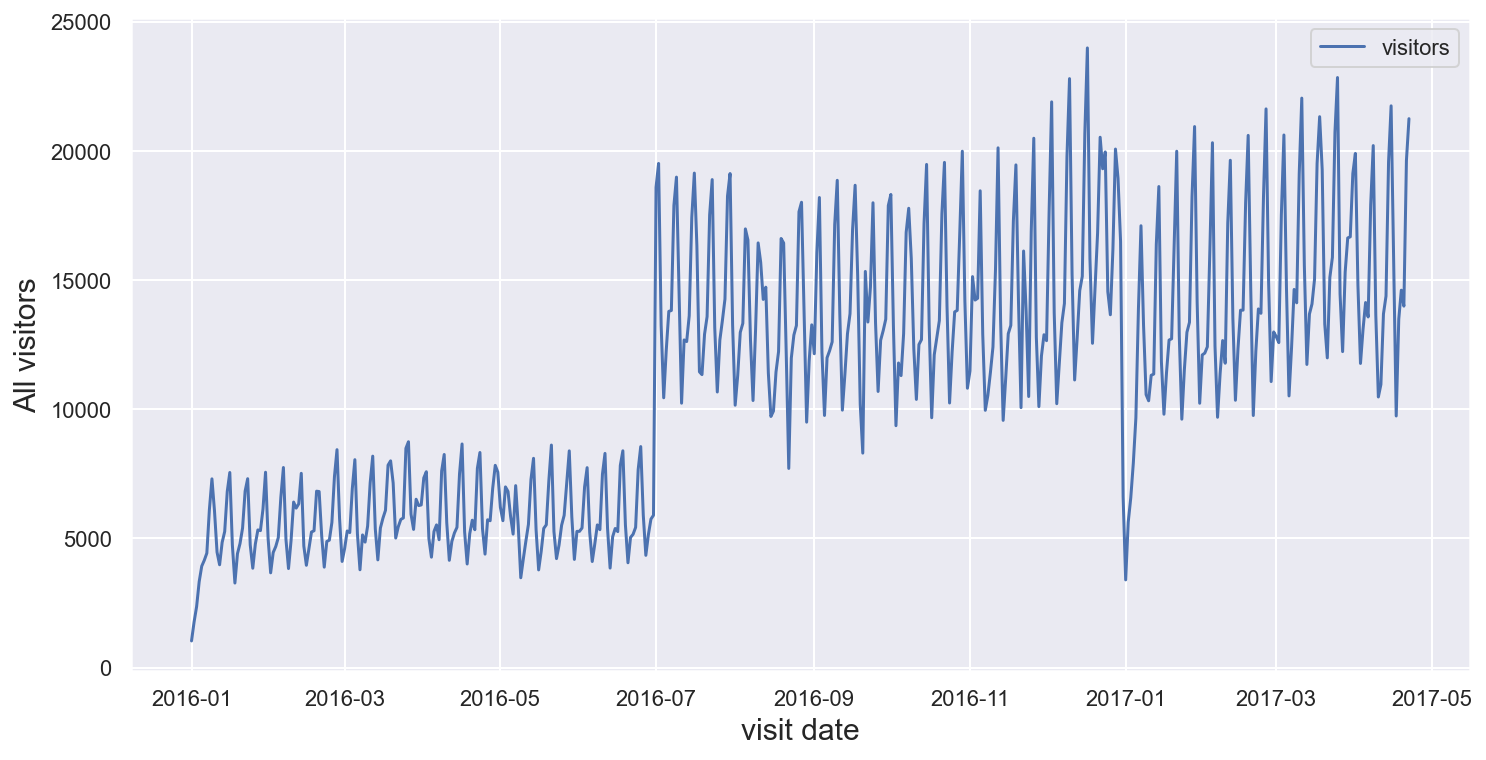

In [25]:
fig,ax = plt.subplots(figsize=(12,6))
visitors_by_date.plot(kind='line', ax=ax)
plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

Observations: 

- There is spike in  increase in total number of visitors in July 2016 ( May be some offer or ... ) 
- There was a big drop in January 2017 ( may be economic disaster or ... )
- A pattern of total number of visitors exists (pattern repeats at regular intervals)

In [26]:
visitors_by_weekday = air_visits.groupby('dow')['visitors'].mean()
visitors_by_weekday

dow
0    17.177009
1    17.672137
2    19.230121
3    18.922702
4    23.072737
5    26.313688
6    23.873362
Name: visitors, dtype: float64

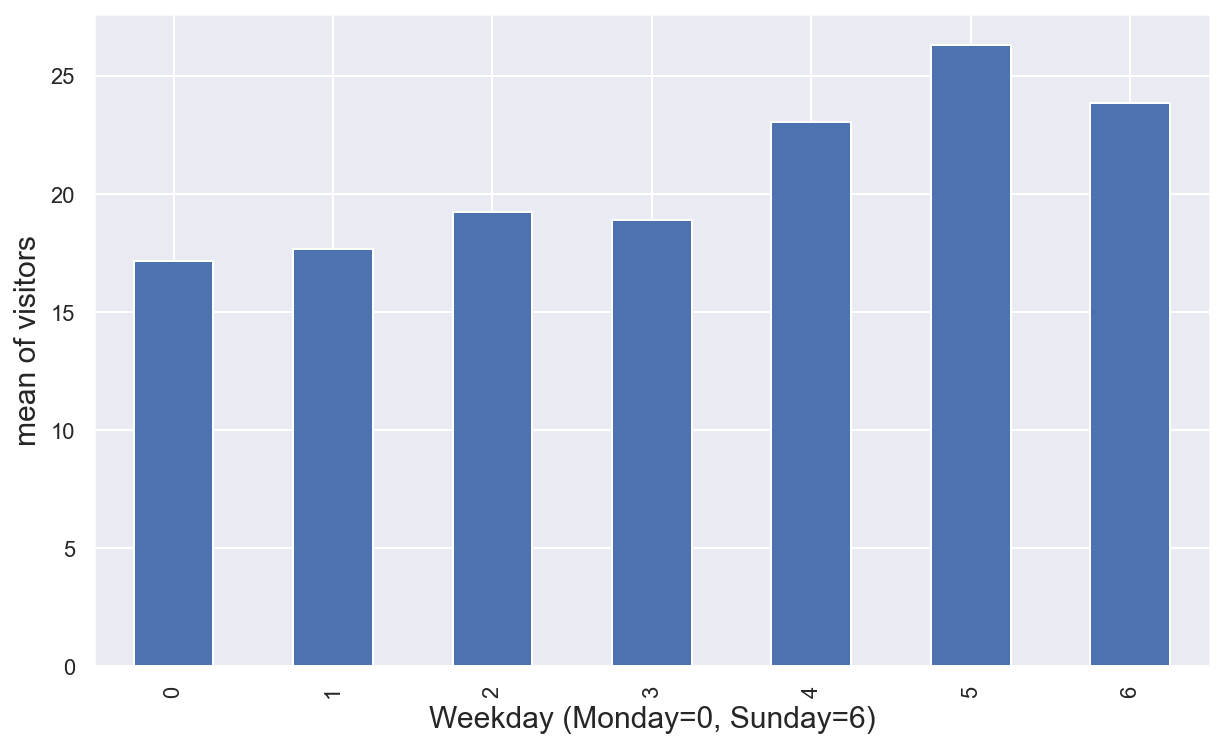

In [27]:
fig,ax = plt.subplots(figsize=(10,6))

visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Weekday (Monday=0, Sunday=6)',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()

Observations :
 
- The average number of visitors on Friday, Saturday and Sunday is higher than on other days

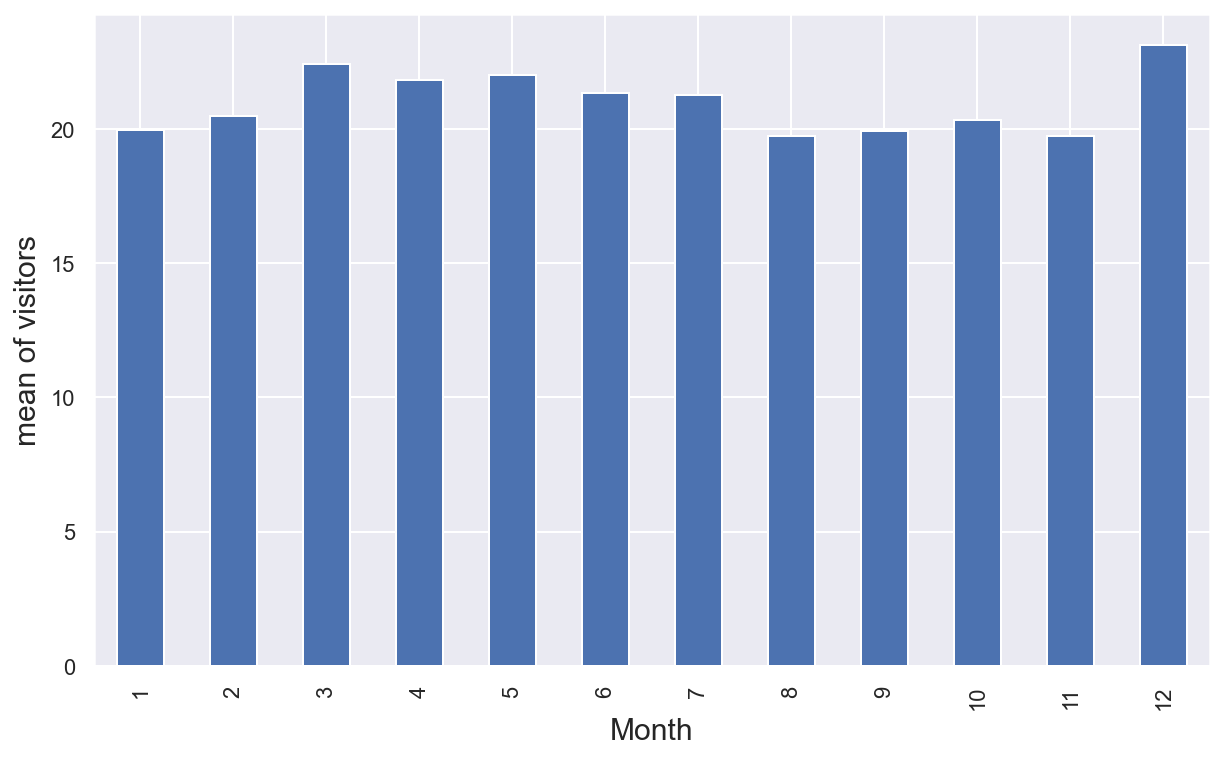

In [28]:
visitors_by_month = air_visits.groupby('month')['visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_month.plot(kind='bar', ax=ax)
plt.xlabel('Month',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()



Observations: 

- In december, there is high number of visitors.
- March, April, May is also more popular than other months. 




In [29]:
test_2016_data = air_visits[air_visits['visit_date'].isin(pd.date_range('2016-04-15', '2017-06-15'))]
test_2016_data_visitors = test_2016_data.groupby('visit_date').agg({'visitors': np.sum})

In [30]:
test_2016_data_visitors

,visitors
visit_date,


In [31]:
# air_visits[air_visits['visit_date'].isin(pd.date_range('2016-04-15', '2016-06-16'))]

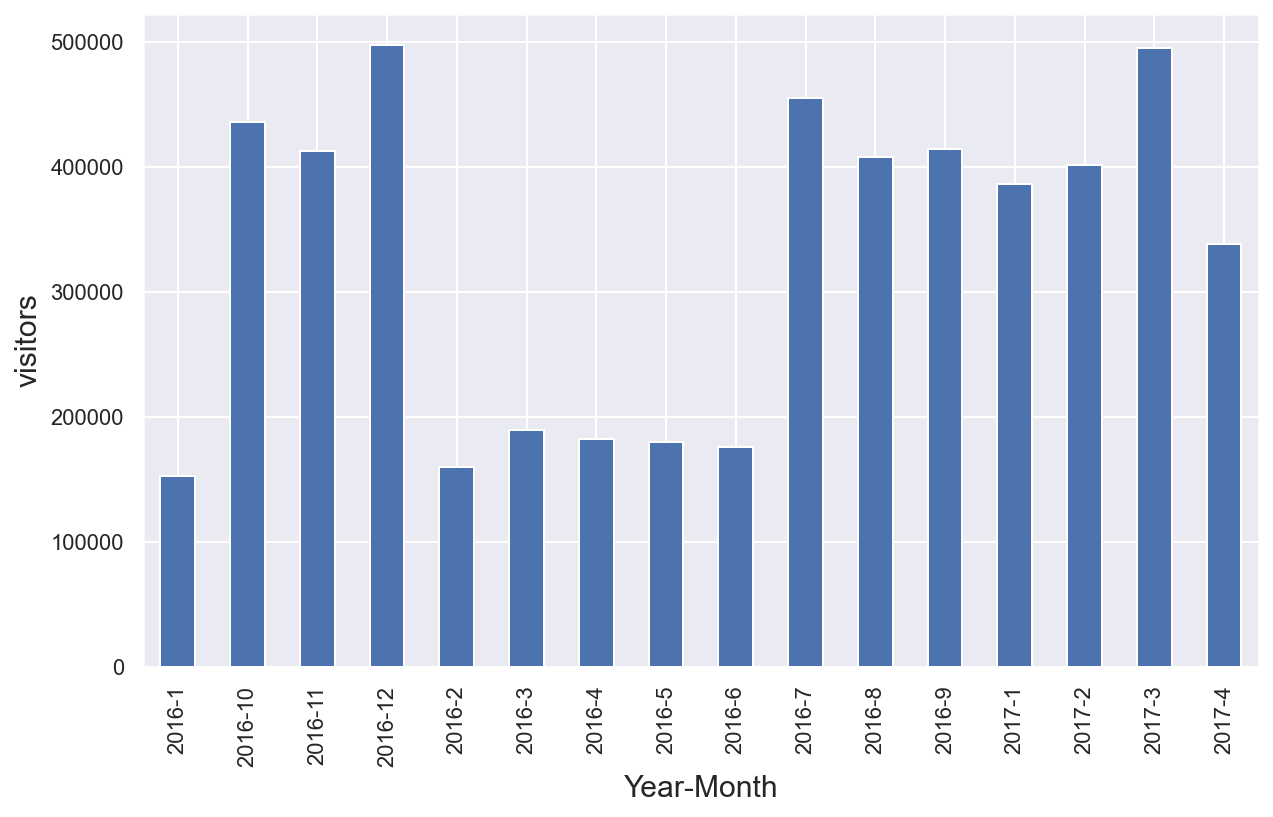

In [32]:
visitors_by_weekday = air_visits.groupby('year_mth')['visitors'].sum()
fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Year-Month',fontsize=15)
plt.ylabel('visitors',fontsize=15)
plt.show()

##### Average number of visitors per restaurant

In [33]:
air_visits.air_store_id.nunique()

# There are total 829 unique restaurant

829

In [34]:
air_visits.groupby('air_store_id').agg({'visitors':np.mean}).describe()

,visitors
count,829.000000
mean,21.203887
std,11.774992
min,1.187500
25%,11.812010
50%,19.183406
75%,28.645161
max,115.470588


In [35]:
mean_visitor_by_res = air_visits.groupby('air_store_id').agg({'visitors':np.mean})
mean_visitor_by_res

,visitors
air_store_id,
air_00a91d42b08b08d9,26.081897
air_0164b9927d20bcc3,9.248322
air_0241aa3964b7f861,9.896465
air_0328696196e46f18,7.939655
air_034a3d5b40d5b1b1,14.828685
...,...
air_fea5dc9594450608,14.485401
air_fee8dcf4d619598e,26.027778
air_fef9ccb3ba0da2f7,9.620408


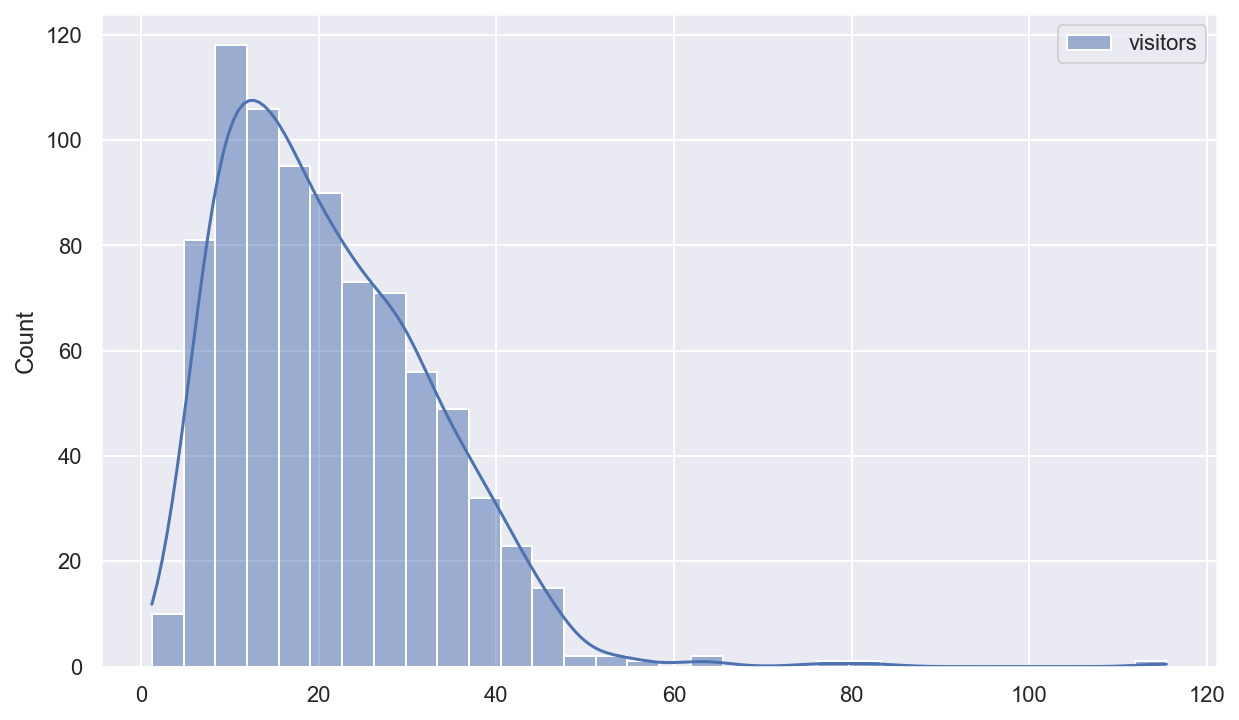

In [36]:
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(mean_visitor_by_res, kde=True)
plt.show()

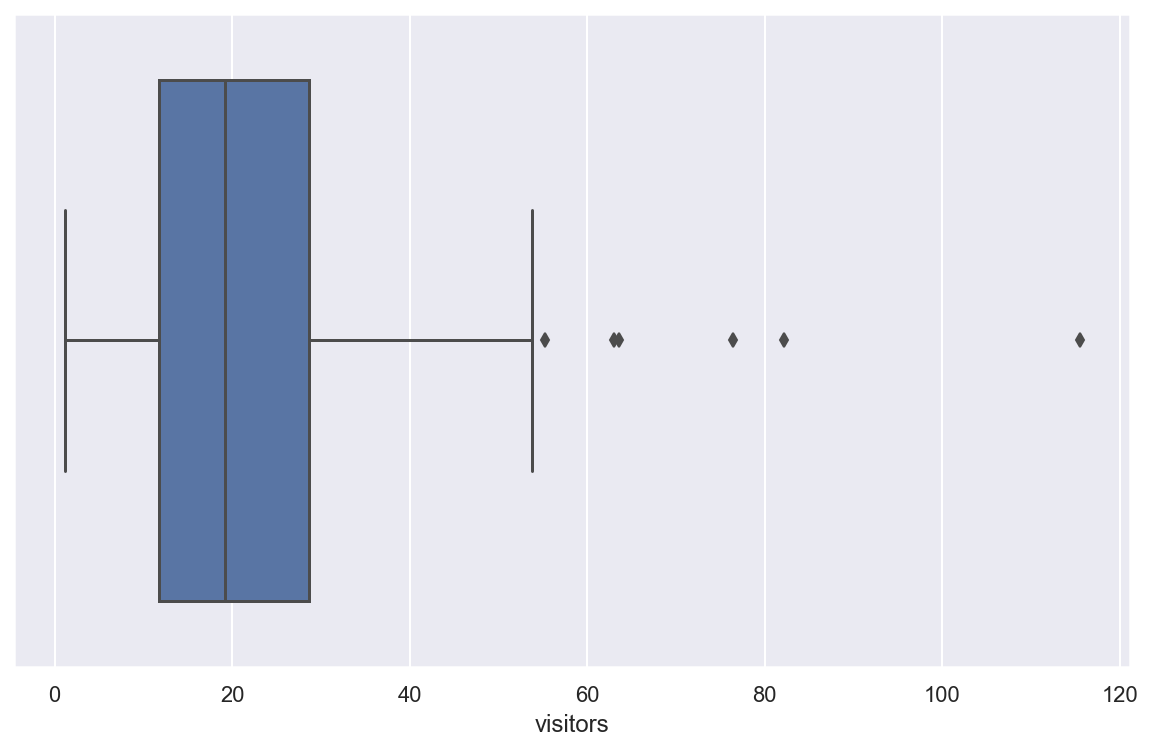

In [37]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(mean_visitor_by_res['visitors'])
plt.show()

Observations:

- Number of restaurant : 829
- Average number of visitors to each store, is  21 
- Maximum : 50 to 60 
- Minimum is 1 person. 

To find why the distribution is left skewed we can get the average number visitors for each restaurant. This also helps in finding possible outliers.

In [38]:
mean = pd.DataFrame(air_visits.groupby('air_store_id').agg({'visitors':np.mean}))

In [39]:
mean

,visitors
air_store_id,
air_00a91d42b08b08d9,26.081897
air_0164b9927d20bcc3,9.248322
air_0241aa3964b7f861,9.896465
air_0328696196e46f18,7.939655
air_034a3d5b40d5b1b1,14.828685
...,...
air_fea5dc9594450608,14.485401
air_fee8dcf4d619598e,26.027778
air_fef9ccb3ba0da2f7,9.620408


In [40]:
air_visits = pd.merge(air_visits, mean, how='left', on='air_store_id')

In [41]:
air_visits = air_visits.rename(columns={"visitors_x": "visitors", "visitors_y": "mean_visitors"}) # 컬럼명 mean_visitors로 변경

In [42]:
air_visits

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1,22.782609
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1,22.782609
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1,22.782609
...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,18,1,2017,4,16,2,2017-4,5.568376
252104,air_24e8414b9b07decb,2017-04-19,6,19,2,2017,4,16,2,2017-4,5.568376
252105,air_24e8414b9b07decb,2017-04-20,7,20,3,2017,4,16,2,2017-4,5.568376
252106,air_24e8414b9b07decb,2017-04-21,8,21,4,2017,4,16,2,2017-4,5.568376


In [43]:
air_visits[air_visits['mean_visitors']> 54].air_store_id.unique()

array(['air_1c0b150f9e696a5f', 'air_df554c4527a1cfe6',
       'air_9c6787aa03a45586', 'air_258dc112912fc458',
       'air_789103bf53b8096b', 'air_900d755ebd2f7bbd'], dtype=object)

In [44]:
print(f"Monday: {0}")

air_visits[air_visits['air_store_id'] == 'air_1c0b150f9e696a5f']
air_visits[air_visits['air_store_id'] == 'air_df554c4527a1cfe6']
air_visits[air_visits['air_store_id'] == 'air_9c6787aa03a45586']
air_visits[air_visits['air_store_id'] == 'air_258dc112912fc458']
air_visits[air_visits['air_store_id'] == 'air_789103bf53b8096b']
air_visits[air_visits['air_store_id'] == 'air_900d755ebd2f7bbd']

Monday: 0


,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
158186,air_900d755ebd2f7bbd,2017-03-02,4,2,3,2017,3,9,1,2017-3,82.2
158187,air_900d755ebd2f7bbd,2017-04-01,47,1,5,2017,4,13,2,2017-4,82.2
158188,air_900d755ebd2f7bbd,2017-04-02,54,2,6,2017,4,13,2,2017-4,82.2
158189,air_900d755ebd2f7bbd,2017-04-04,79,4,1,2017,4,14,2,2017-4,82.2
158190,air_900d755ebd2f7bbd,2017-04-05,82,5,2,2017,4,14,2,2017-4,82.2
158191,air_900d755ebd2f7bbd,2017-04-06,89,6,3,2017,4,14,2,2017-4,82.2
158192,air_900d755ebd2f7bbd,2017-04-07,84,7,4,2017,4,14,2,2017-4,82.2
158193,air_900d755ebd2f7bbd,2017-04-08,67,8,5,2017,4,14,2,2017-4,82.2
158194,air_900d755ebd2f7bbd,2017-04-09,50,9,6,2017,4,14,2,2017-4,82.2
158195,air_900d755ebd2f7bbd,2017-04-11,75,11,1,2017,4,15,2,2017-4,82.2


Observations: 

- A sharp increase in the number of visitors( left skewed) over the weekend affected the average.



# HPG Reservation Data

In [45]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [46]:
print('Total hpg reserve visitors - ',hpg_reserve['reserve_visitors'].sum())

Total hpg reserve visitors -  10149193


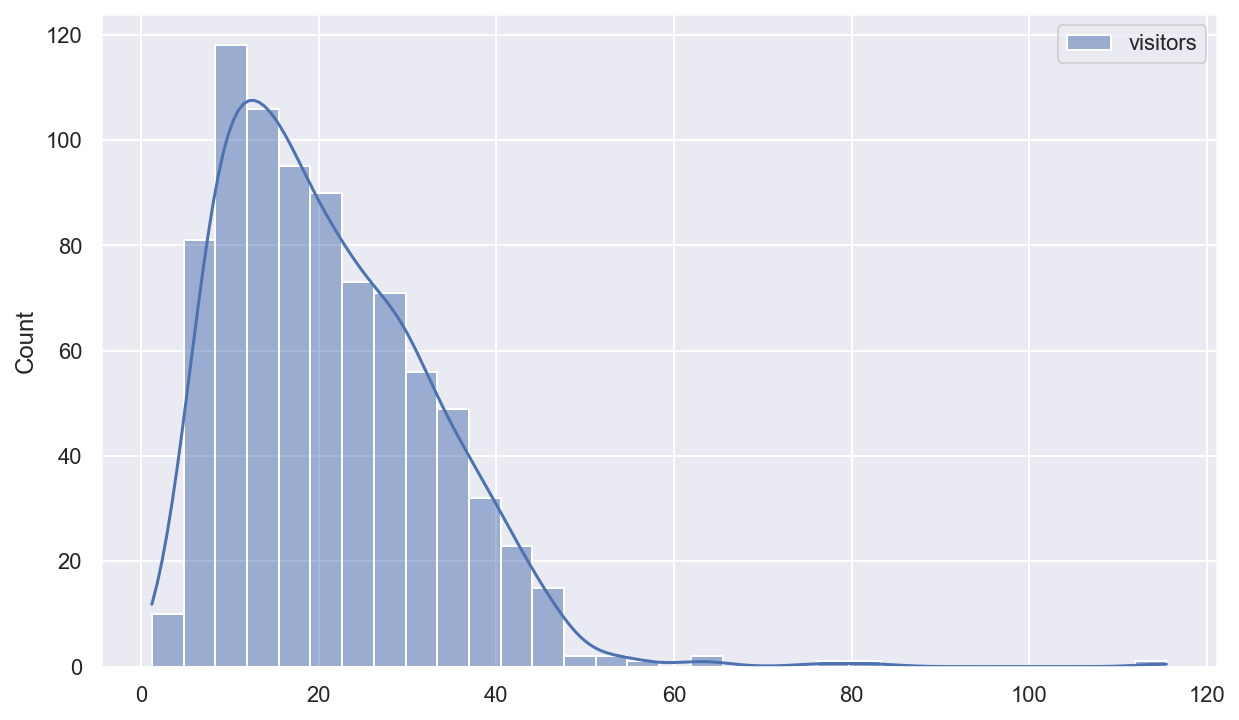

In [47]:
# Average number of booking visitors per restaurant

mean_reserve_byres = hpg_reserve.groupby('hpg_store_id').agg({'reserve_visitors':np.mean})
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(mean_visitor_by_res, kde=True)
plt.show()

In [48]:
mean_reserve_byres.describe()

,reserve_visitors
count,13325.000000
mean,5.990761
std,3.955656
min,1.192857
25%,3.967742
50%,5.125000
75%,6.915493
max,84.000000


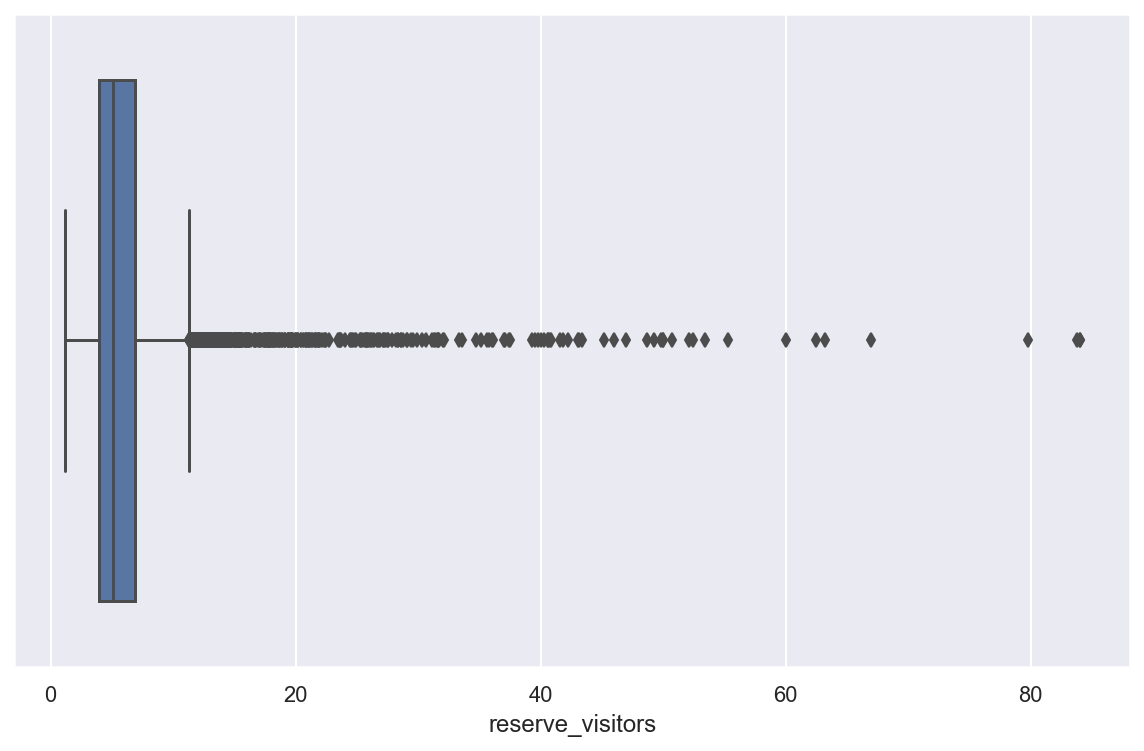

In [49]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(mean_reserve_byres['reserve_visitors'])
plt.show()

Observations :
    
- The average number of reservation visitors per restaurant is about 5, 
- Yhe number of reservations is between 5 and 12.


In [50]:
hpg_reserve = pd.merge(hpg_reserve, mean_reserve_byres, how='left', on='hpg_store_id')
hpg_reserve = hpg_reserve.rename(columns={"reserve_visitors_x": "reserve_visitors", "reserve_visitors_y": "mean_reserve_visitors"})


In [51]:
hpg_reserve

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,mean_reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,4.947761
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2.381967
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,4.904040
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,8.312500
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,3.873950
...,...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2,9.560976
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3,3.274924
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49,12.500000
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9,3.100402


In [52]:
hpg_reserve[hpg_reserve['mean_reserve_visitors']> 11.34].hpg_store_id.unique()
print(len(hpg_reserve[hpg_reserve['mean_reserve_visitors']> 11.34].hpg_store_id.unique()))


575


There are 575 bookings with IQR range of 11.34 or more. (Total 13325)

**Time of visit**

In [53]:
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['visit_hour'] = hpg_reserve['visit_datetime'].dt.hour

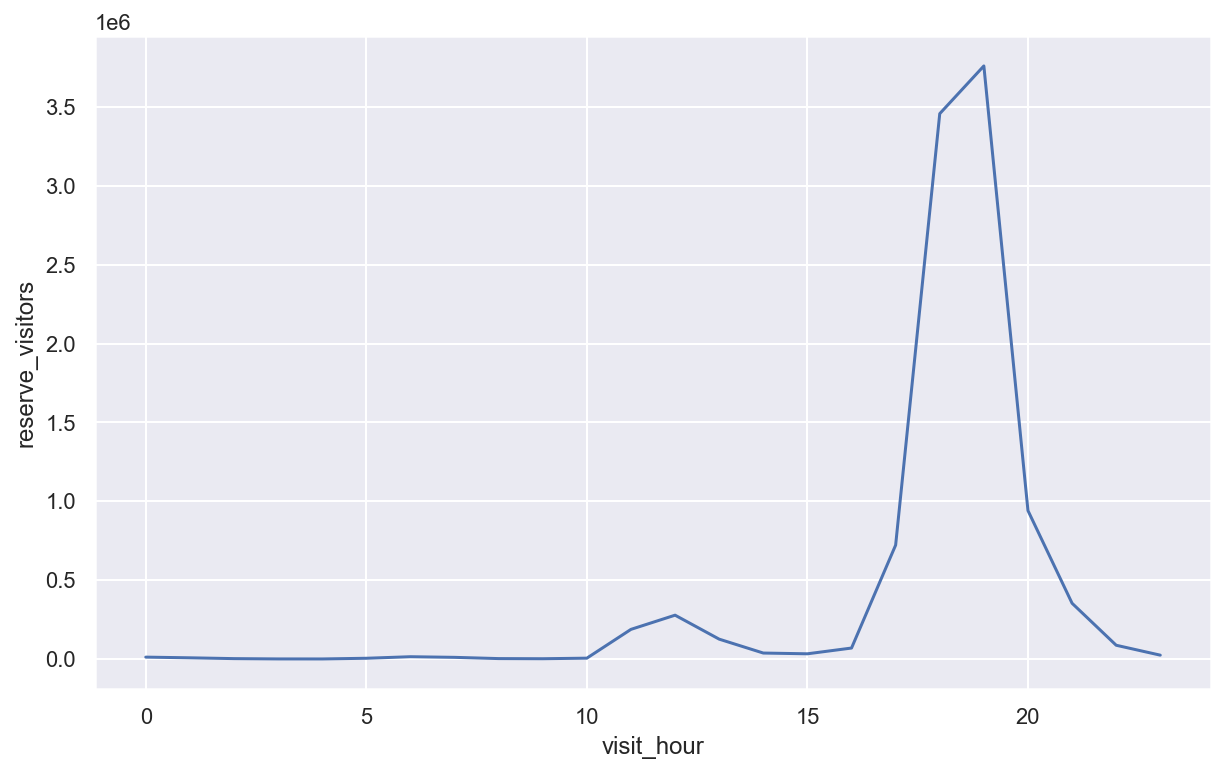

In [54]:
time_reserve = hpg_reserve.groupby('visit_hour').agg({'reserve_visitors':np.sum})
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='visit_hour', y='reserve_visitors', data=time_reserve)
plt.show()

Observations:

- Evening reservations are more

**Restaurant according to Genre**

In [55]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [56]:


res_by_genre = pd.DataFrame(hpg_store.groupby(['hpg_genre_name'])['hpg_store_id'].value_counts()).groupby('hpg_genre_name').agg({'hpg_store_id':np.sum})
res_by_genre.sort_values(by='hpg_store_id', ascending=False)



,hpg_store_id
hpg_genre_name,
Japanese style,1750
International cuisine,700
Creation,410
Seafood,339
Grilled meat,325
Italian,249
Spain Bar/Italian Bar,229
Chinese general,91
Japanese food in general,85


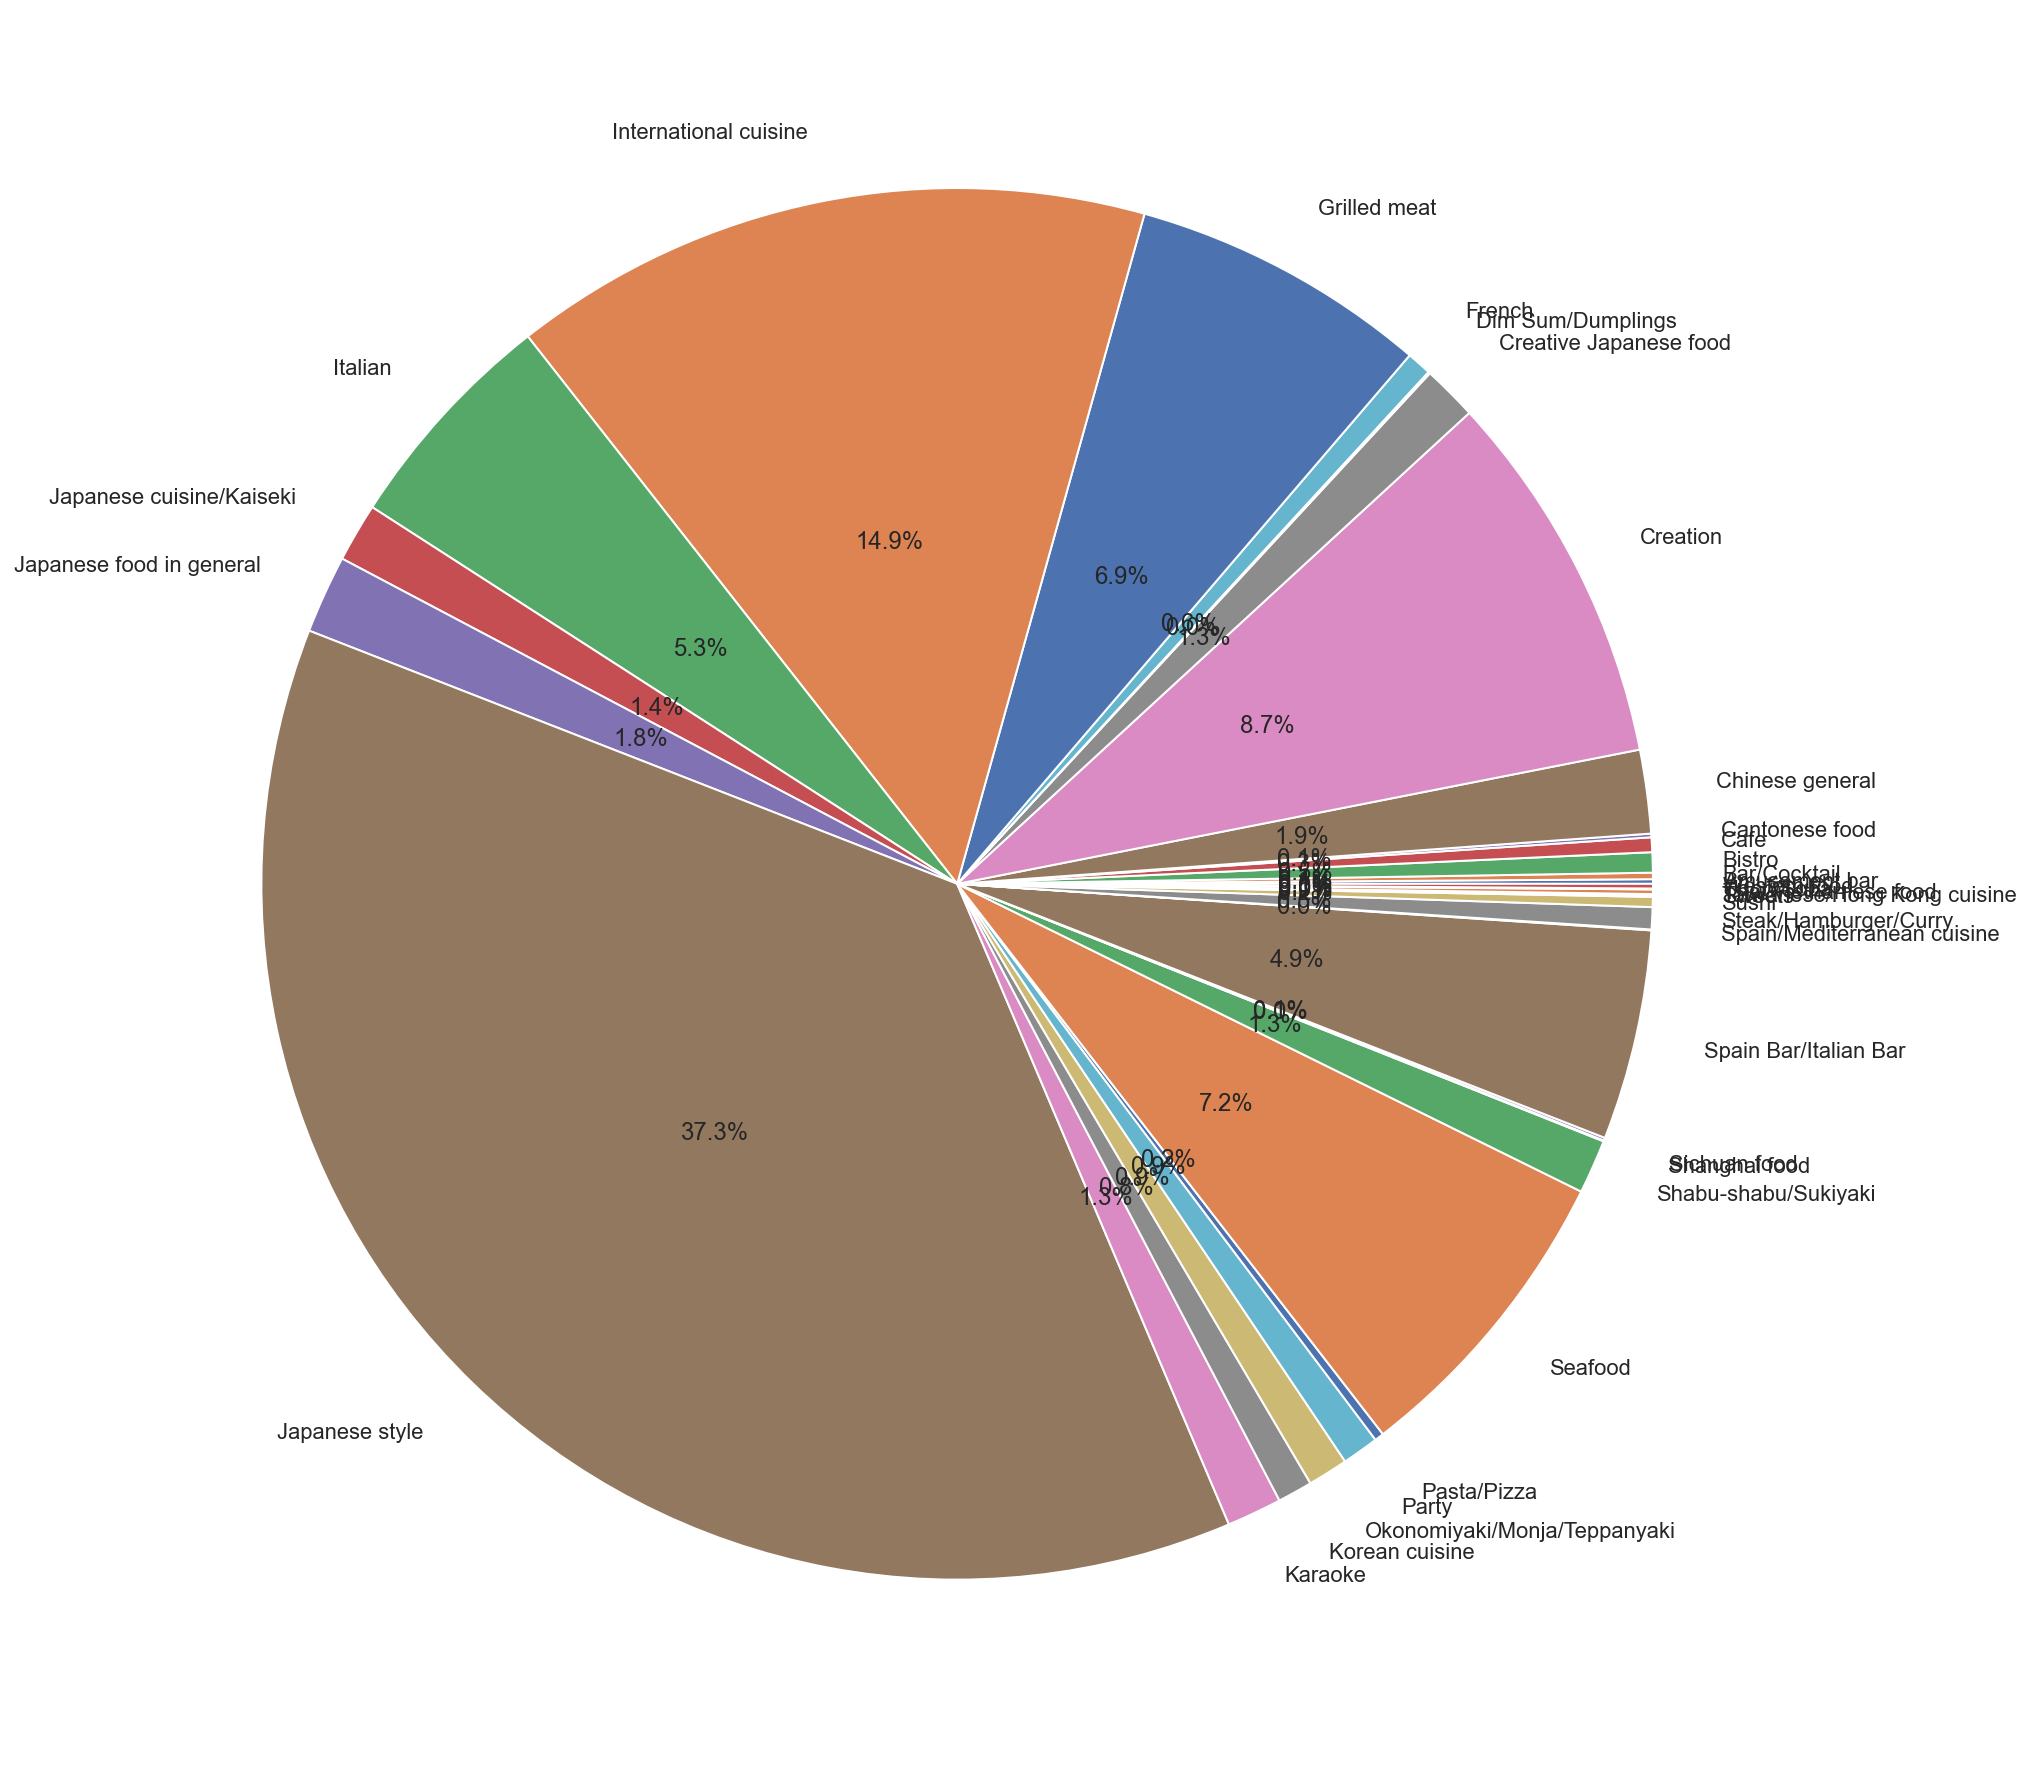

In [57]:
from matplotlib import pyplot as plt
pie, ax = plt.subplots(figsize=[35,16])
plt.pie(res_by_genre['hpg_store_id'], labels=res_by_genre['hpg_store_id'].keys(), autopct='%0.1f%%',pctdistance=0.5)
plt.show()

Observations:
    
- HPG restaurants are subdivided into 34 genres. 
- Japanese style accounts for the largest portion with 37.3%, 
- International cusine with 14.9%

**Number of reservations by genre**

In [58]:
hpg_full = pd.merge(hpg_reserve, hpg_store, how='left', on='hpg_store_id')
hpg_full.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,mean_reserve_visitors,visit_hour,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,4.947761,11,NaN,NaN,NaN,NaN
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2.381967,13,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,4.904040,16,NaN,NaN,NaN,NaN
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,8.312500,17,NaN,NaN,NaN,NaN
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,3.873950,17,NaN,NaN,NaN,NaN


In [59]:
visitor_by_genre = hpg_full.groupby('hpg_genre_name').agg({'reserve_visitors': np.sum})
visitor_by_genre

,reserve_visitors
hpg_genre_name,
Amusement bar,1966
Bar/Cocktail,5108
Bistro,15670
Cafe,15635
Cantonese food,3581
Chinese general,76689
Creation,393471
Creative Japanese food,52543
Dim Sum/Dumplings,1609


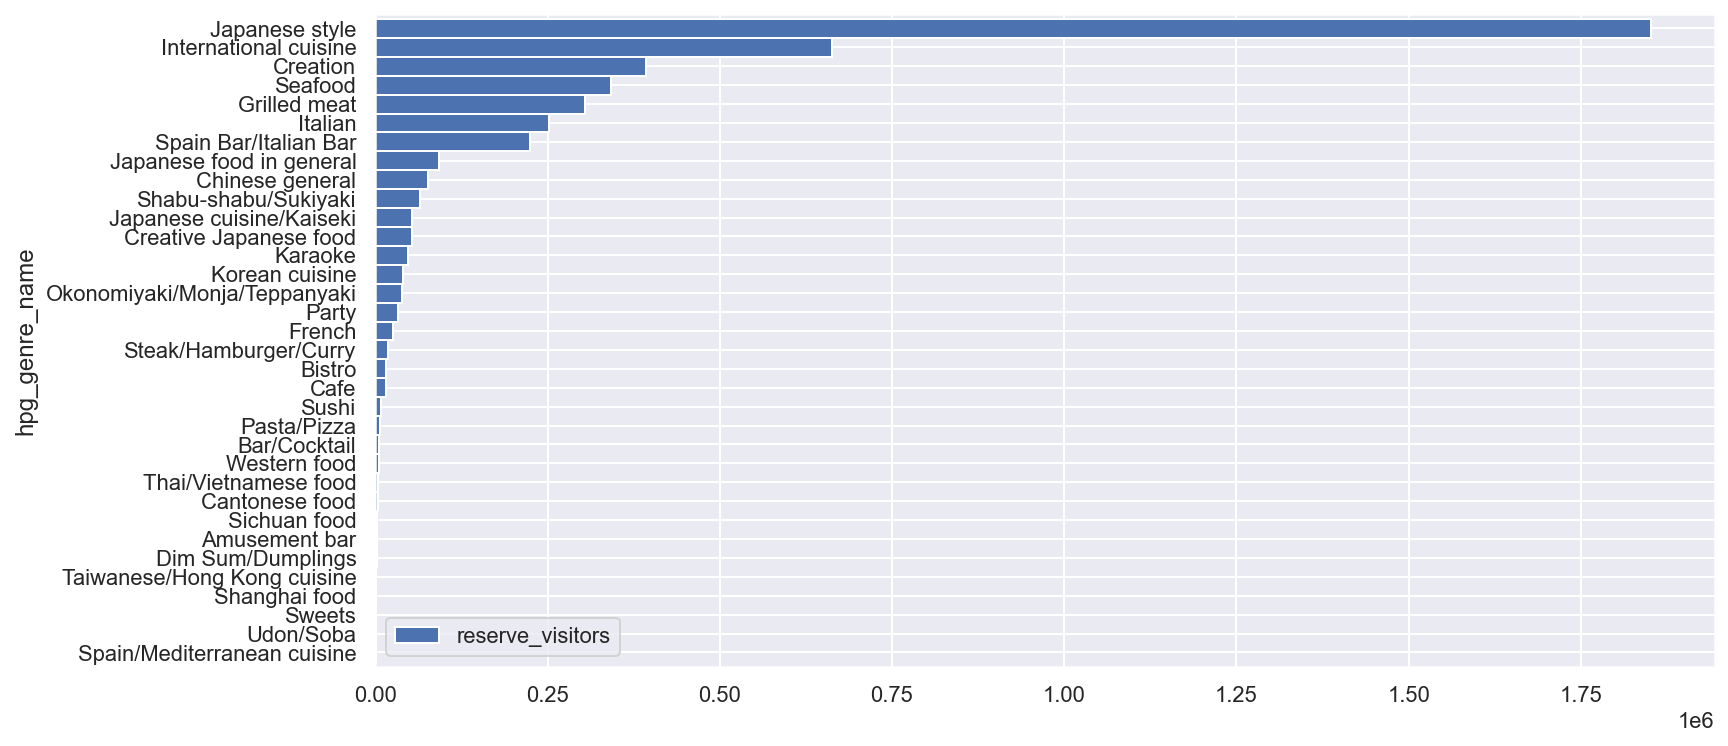

In [60]:
fig,ax = plt.subplots(figsize=(12,6))
visitor_by_genre.sort_values(by='reserve_visitors', ascending=True).plot(kind='barh', width=1,ax=ax)
plt.show()

Observations:
    
- The most popular restaurant among the people is japanase style, international cusine, creation, seafood, and grilled meat.

# HoliDay 

Characteristics of Japanese public holidays
- If a Sunday and a public holiday overlap, an alternative holiday system is implemented in which the next weekday is a holiday.

- Among public holidays, the Happy Monday system is applied to Coming-of-Age Day, Ocean Day, Respect for the Aged Day, and Sports Day, so it is always Monday.

- Golden Week is held around the end of April-early May every year.
         2016: 4/27-5/5
         2017: 4/27-5/5
     

Relationship between air_visit_data and date_info

In [61]:
holidays

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [62]:
air_visits

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1,22.782609
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1,22.782609
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1,22.782609
...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,18,1,2017,4,16,2,2017-4,5.568376
252104,air_24e8414b9b07decb,2017-04-19,6,19,2,2017,4,16,2,2017-4,5.568376
252105,air_24e8414b9b07decb,2017-04-20,7,20,3,2017,4,16,2,2017-4,5.568376
252106,air_24e8414b9b07decb,2017-04-21,8,21,4,2017,4,16,2,2017-4,5.568376


In [63]:
air_visit_with_date_info = pd.merge(air_visits, holidays, left_on="visit_date", right_on="calendar_date")
air_visit_with_date_info




,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors,calendar_date,day_of_week,holiday_flg


In [64]:
air_visit_with_date_info.drop(["calendar_date"], axis=1, inplace=True)
air_visit_with_date_info.head()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors,day_of_week,holiday_flg


Difference in the average number of visitors on weekdays and weekends?

In [65]:
air_visit_with_date_info['visit_day_of_week'] = pd.to_datetime(air_visit_with_date_info['visit_date']).dt.dayofweek

In [66]:
air_visit_with_date_info

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors,day_of_week,holiday_flg,visit_day_of_week


In [67]:
air_visit_with_date_info['weekend_flg'] = ((air_visit_with_date_info['visit_day_of_week']>4)).astype(int)

In [68]:
# Saturday and Sunday are weekends
air_visit_with_date_info

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors,day_of_week,holiday_flg,visit_day_of_week,weekend_flg


<AxesSubplot:>

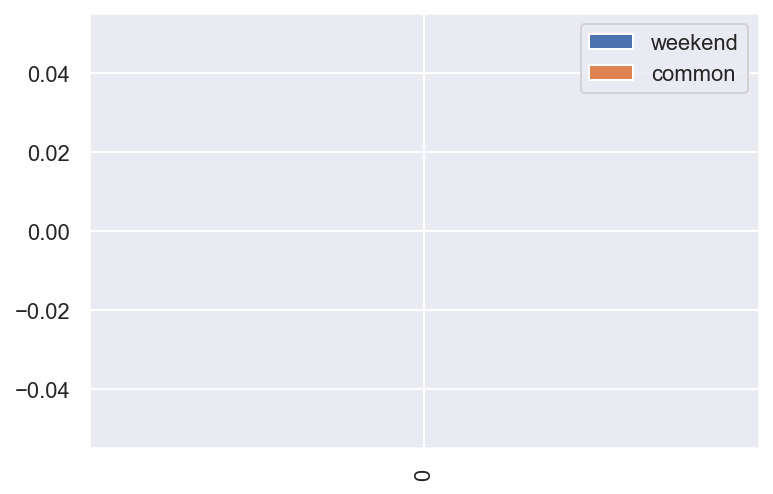

In [69]:
temp_df = pd.DataFrame()

query = "weekend_flg == 1"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

query = "holiday_flg == 0 & weekend_flg == 0"
temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

temp_df.plot(kind="bar")

Observations:
    
- On weekend average number of visistors are more

Does Friday-Saturday have more visitors on average than Saturday-Sunday?

<AxesSubplot:>

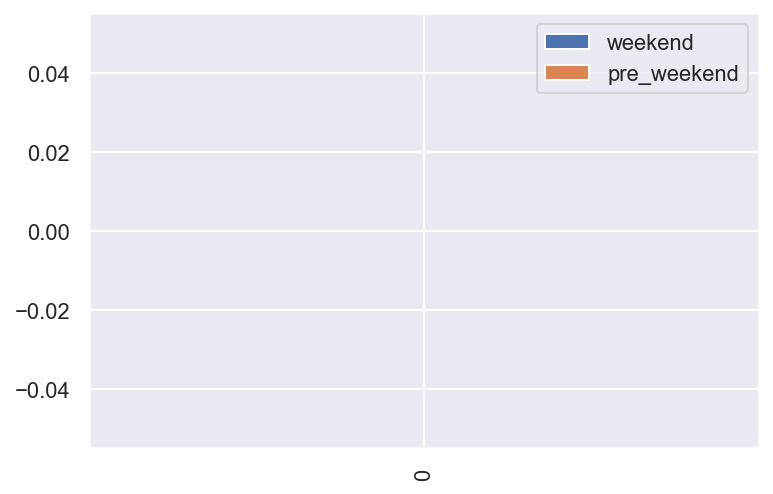

In [70]:
air_visit_with_date_info['pre_weekend_flg'] = ((air_visit_with_date_info['visit_day_of_week']>3) & (air_visit_with_date_info['visit_day_of_week']<6)).astype(int)

temp_df = pd.DataFrame()

query = "weekend_flg == 1"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].sum()]

query = "pre_weekend_flg == 0"
temp_df["pre_weekend"] = [air_visit_with_date_info.query(query)["visitors"].sum()]

temp_df.plot(kind="bar")

Observations:

- Friday-Saturday has a lot more visitors than weekends (Is it the effect of karaoke or bars?)

Are there, on average, more visitors on holidays other than weekends?

<AxesSubplot:>

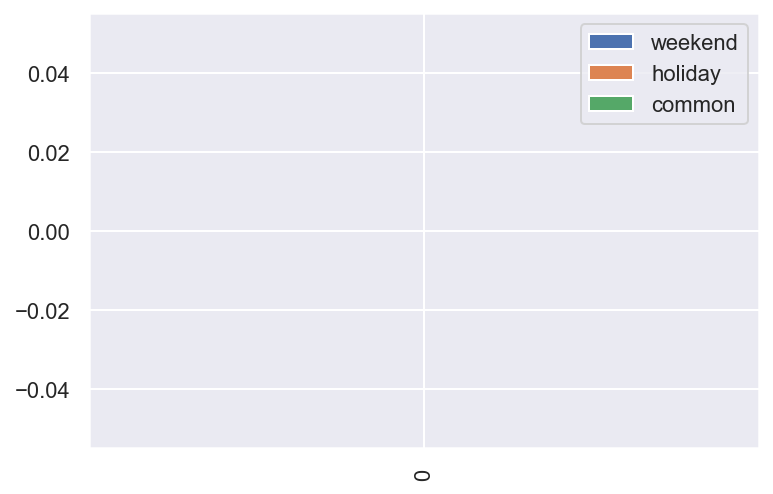

In [71]:
temp_df = pd.DataFrame()

query = "weekend_flg == 1"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

query = "holiday_flg == 1"
temp_df["holiday"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

query = "holiday_flg == 0 & weekend_flg == 0"
temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

temp_df.plot(kind="bar")

Observations:

- Weekends > Holidays > Weekdays are the most visited visitors.

Are there as many visitors as the Friday-Saturday case on the eve of the holiday?

<AxesSubplot:>

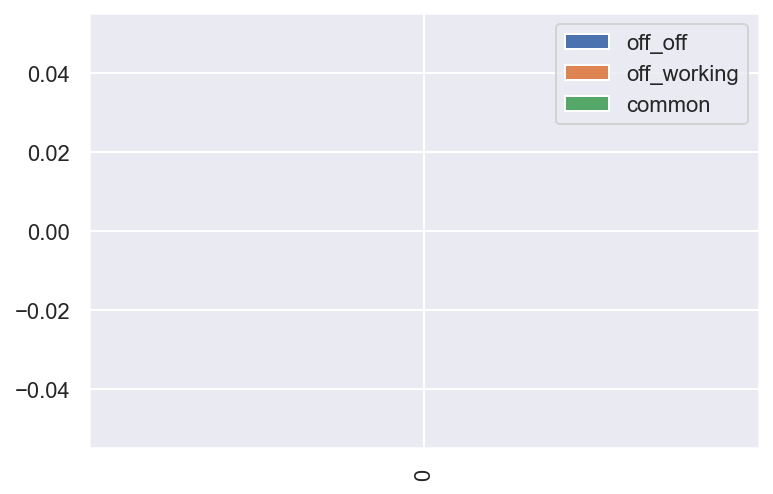

In [72]:
air_visit_with_date_info['off_day_flg'] = ((air_visit_with_date_info['weekend_flg']==1) | (air_visit_with_date_info['holiday_flg']==1)).astype(int)
air_visit_with_date_info['next_day_is_off_day'] = air_visit_with_date_info['off_day_flg'].shift(-1,fill_value=0).astype(int)

temp_df = pd.DataFrame()

query = "next_day_is_off_day == 1"
temp_df["off_off"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "off_day_flg == 1 & next_day_is_off_day==0"
temp_df["off_working"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "off_day_flg == 0"

temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]


temp_df.plot(kind="bar")



Observations:


- If the next day is a holiday, there are many visitors.

- If today is a holiday and the next day is not a holiday, the average number of visitors is low.

